<a href="https://www.kaggle.com/code/deeparker/optiver-model-comparison-and-ensemble?scriptVersionId=191556718" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<font size="4"> Optiver - Trading at the Close (Kaggle Competition Submission)

<font size="4"> *Please note an example Kaggle notebook was cited in this project. The notebook provides great examples of newly generated features derived from the features provided in the dataset.*

<font size="4"> *The link to the notebook can be found here:*
<font size="4"> https://www.kaggle.com/code/kononenko/tuned-lgbm-best-public-score - *"[tuned LGBM] Best Public Score" - Oleksiy Kononenko*

<font size="4"> This notebook is a Kaggle submission for the "Optiver - Trading at the Close" competition. The purpose of this notebook is to demonstrate general data exploration techniques, model comparison, and ensembling. This is intended to be the first portfolio project available on my GitHub page. I hope this notebook may help newcomers get a general understanding of techniques that may be used to analyze datasets and improve predictions with popular machine learning algorithms (LightGBM, Xgboost, Catboost, and Tensorflow/Keras). Note that for simplicity, this notebook will run using CPU processing rather than GPU.It is recommended to use the GPU features available in modules such at LightGBM and Catboost. 

<font size="4"> A description of the competition below can be found below. This was copied from the competition website:

<font size="4"> https://www.kaggle.com/competitions/optiver-trading-at-the-close/overview



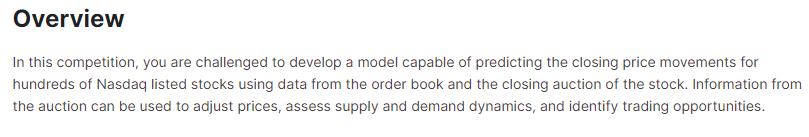

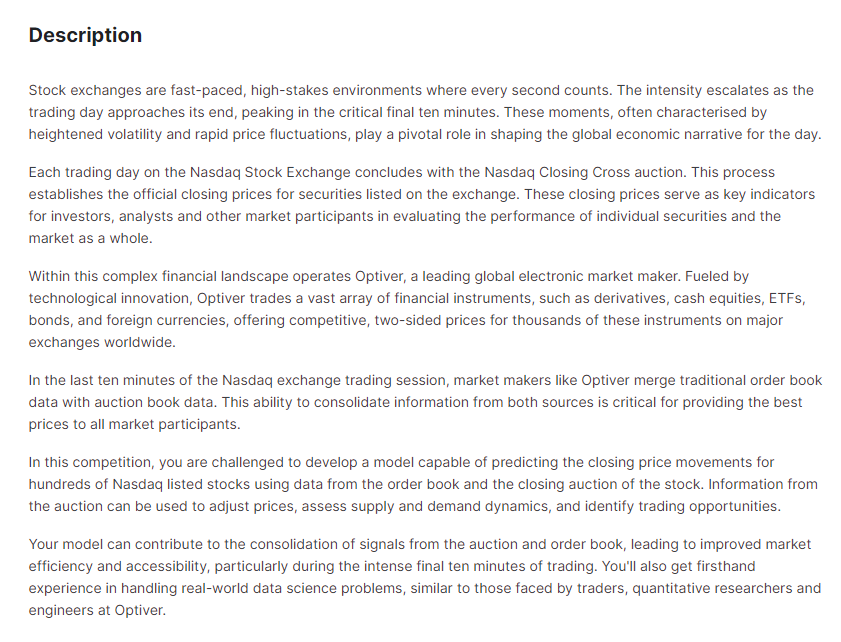

## Column names and description of columns in the data set:

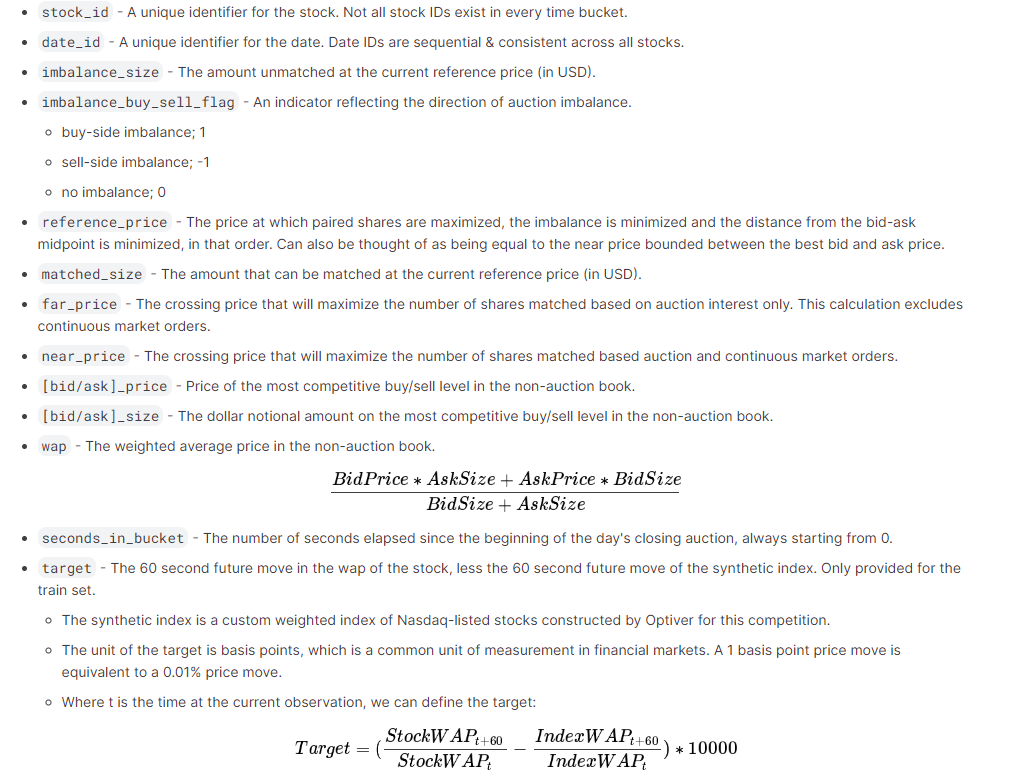

## Note the target metric, "Mean Absolute Error" defined below. 

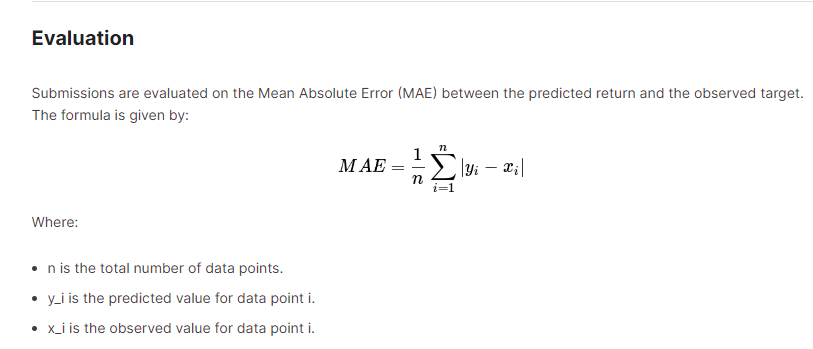

<font size="4">  To begin, we first import required packages and load the training and test data sets.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import sklearn
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
train_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
test_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')

In [3]:
train_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
test_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290,478_0_4,False


In [5]:
train_df.shape

(5237980, 17)

<font size="4">  The dataset is quite large. Kaggle users often defer to "memory friendly" algorithms such as gradient decent algorithms (LightGBM, XGBoost, CatBoost) and Neural Networks. We will explore these algorithms with this data set.

<font size="4">  Lets see if any columns have missing values.

In [6]:
# Calculate the number of missing values in each column
missing_values_per_col = train_df.isna().sum(axis=0)
print(missing_values_per_col)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64


<font size="4"> The columns "far_price" and "near_price" both have a significant number of missing values. We can examine to find out the nature of why there may be so many missing values.

In [7]:
train_df['far_price'].head(1000)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
995   NaN
996   NaN
997   NaN
998   NaN
999   NaN
Name: far_price, Length: 1000, dtype: float64

In [8]:
train_df['far_price'].tail(1000)

5236980    0.999017
5236981    0.996121
5236982    0.998040
5236983    0.998338
5236984    0.997493
             ...   
5237975    0.999734
5237976    1.000129
5237977    0.995789
5237978    0.999210
5237979    1.000859
Name: far_price, Length: 1000, dtype: float64

<font size="4">  It appears the missing values may appear at the top of the column, while the end values are filled. Let's confirm if this is the case.

In [9]:
column_name = 'far_price'
missing_value_encountered = False
valid_entry_count = 0

# Iterate from the bottom of the DataFrame
for index in reversed(train_df.index):
    value = train_df.at[index, column_name]
    
    # Check if the value is not missing
    if not pd.isna(value):
        valid_entry_count += 1
    else:
        missing_value_encountered = True
        print("Missing value encountered at index {}. End of valid entries.".format(index))
        break

if missing_value_encountered:
    print("Number of valid data points before the first missing value: {}".format(valid_entry_count))
else:
    print("No missing values found in the '{}' column.".format(column_name))


Missing value encountered at index 5236351. End of valid entries.
Number of valid data points before the first missing value: 1628


<font size="4">  There are 1628 valid entries "from the bottom" before the first NAN value. The nature of the missing values in these columns is unclear. Also, as noted in the competition's description, every second at the trading close counts. Each row represents a unit in time. If we were to include the "far_price" and "near_price" features, it is likely we would be unable to feed data forward to our models in live production, because the "far_price" and "near_price" features would not be available in live time. For this reason, I will not include the "far_price" and "near_price" in the initial model trials. We will use the fillna() function to fill the NAN values with 0's in case we would like to trial models including those features at a later time.

In [10]:
train_df['far_price'].fillna(0, inplace = True)
train_df['near_price'].fillna(0, inplace = True)
# Drop the specified columns
train_df.dropna(inplace = True)
train_df.reset_index(inplace = True)

In [11]:
test_df['far_price'].fillna(0, inplace = True)
test_df['near_price'].fillna(0, inplace = True)
# Drop the specified columns
test_df.dropna(inplace = True)
test_df.reset_index(inplace = True)

In [12]:
train_df.shape

(5237760, 18)

<font size="4">  Check to ensure there are no longer missing values. 

In [13]:
# Calculate the number of missing values in each column
missing_values_per_col = train_df.isna().sum(axis=0)
print(missing_values_per_col)

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64


<font size="4">  Now that we have confirmed there are no missing values, we can get information regarding the target variable using the describe() function. Recall, the target variable is "the 60 second future move in the wap (weighted average price) of the stock, less the 60 second future move of the synthetic index." 

In [14]:
train_df['target'].describe()

count    5.237760e+06
mean    -4.758886e-02
std      9.452816e+00
min     -3.852898e+02
25%     -4.559755e+00
50%     -6.020069e-02
75%      4.409552e+00
max      4.460704e+02
Name: target, dtype: float64

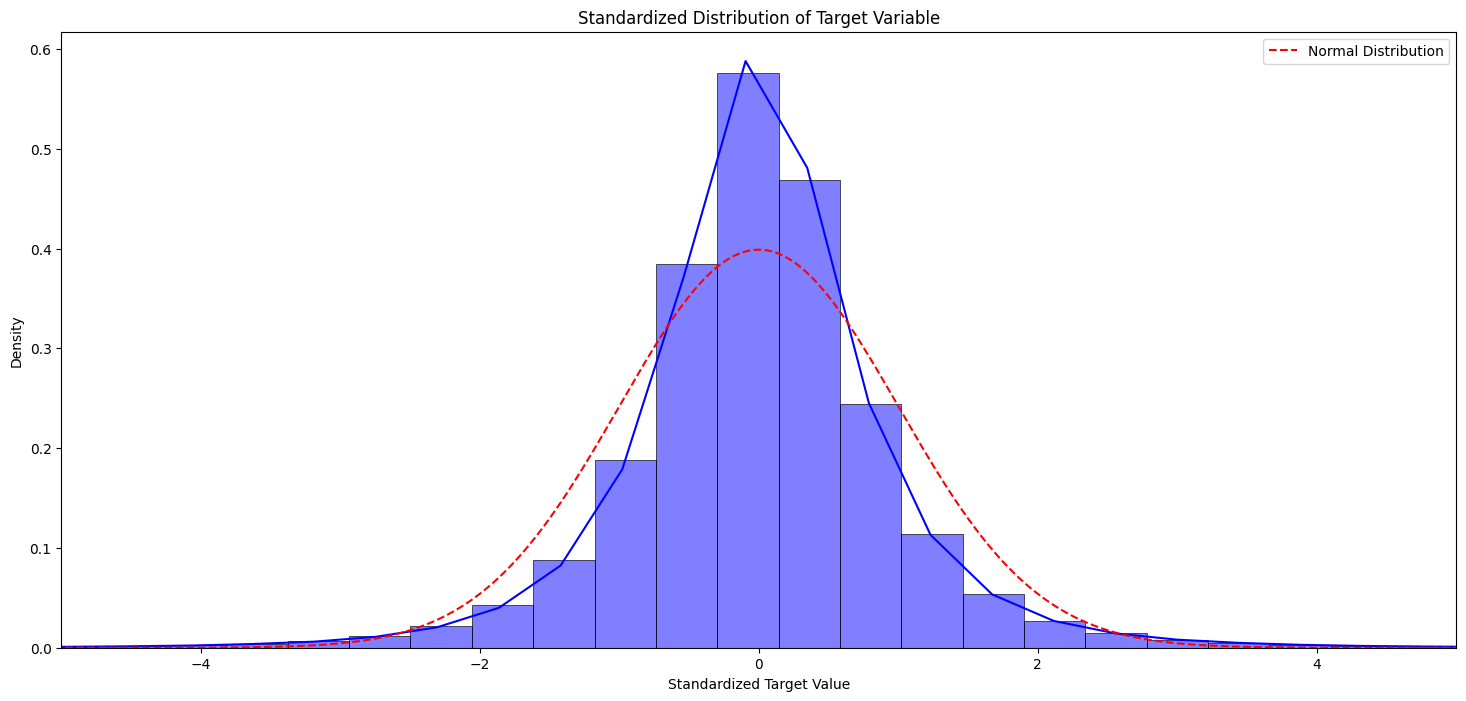

In [15]:
# Standardize the target variable
target_standardized = (train_df['target'] - train_df['target'].mean()) / train_df['target'].std()

plt.figure(figsize=(18, 8))  # Wider figure

# Plot histogram and KDE for the standardized target variable
sns.histplot(target_standardized, bins=200, kde=True, color='blue', stat='density') 

# Plot the normal distribution for comparison
x = np.linspace(-20, 20, 1000)  # Wider range for x
plt.plot(x, norm.pdf(x), color='red', linestyle='--', label='Normal Distribution')

plt.title('Standardized Distribution of Target Variable')
plt.xlabel('Standardized Target Value')
plt.ylabel('Density')
plt.legend()

# Set x-axis limits
plt.xlim(-5, 5)

plt.show()


<font size="4">  The target variable appears to be normally distributed. Recall this is a regression problem. This means our target variable contains continuous values.

<font size="4">  We can also see how many unique dates we have in the data set and also how many unique stocks are included in the data set.

In [16]:
train_df['stock_id'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  70,  71,  72,  73,  74,  75,  76,  77,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 151, 152, 154, 155, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [17]:
len(train_df['stock_id'].unique())

200

In [18]:
len(train_df['date_id'].unique())

481

<font size="4">  There are 200 unique stocks in the training data set, and 481 different date IDs. Note that some rows may contain the same date_id and time_id, however different stock ID's. This represents  the "concurrent" price of each stock at each give period of time.  We can visualize this by looking at the first few rows of data.

In [19]:
train_df.head(20)

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,1,0,0,166603.91,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,2,0,0,302879.87,-1,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,4,0,0,447549.96,-1,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,5,0,0,0.00,0,1.000635,13552875.92,0.0,0.0,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,6,0,0,969969.40,1,1.000115,3647503.98,0.0,0.0,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,7,0,0,9412959.10,1,0.999818,21261245.87,0.0,0.0,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,8,0,0,2394875.85,1,0.999916,9473209.08,0.0,0.0,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,9,0,0,3039700.65,-1,1.000969,6248958.45,0.0,0.0,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


<font size="4">  Lets first try a correlation analysis of the independent variables.

In [20]:
columns_to_remove = ['stock_id', 'date_id', 'time_id', 'row_id']
# Remove the specified columns
corr_df = train_df.drop(columns=columns_to_remove)

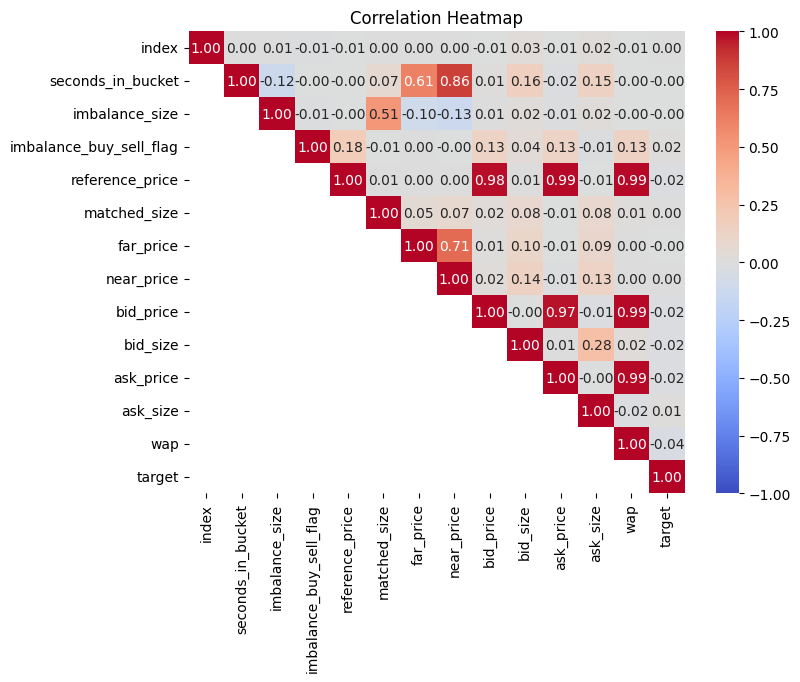

In [21]:
# Calculate the correlation matrix
corr_matrix = corr_df.corr()
# Create a lower triangular mask
mask = ~np.tri(*corr_matrix.values.shape, k=-1, dtype=bool)

# Apply the mask to set the upper triangle values to NaN
corr_matrix = pd.DataFrame(corr_matrix.values * mask, columns=corr_matrix.columns, index=corr_matrix.index)
# Replace very small values with NaN
corr_matrix = corr_matrix.applymap(lambda x: np.nan if abs(x) < 1e-10 else x)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

<font size="4">  With the exception of the correlations related to "price" variables, there are not many strong correlations amongst the variables. We may consider leaving some of the highly correlated features out of our models, as they may offer uneeded "noise" to the model, which could lead to overfitting. 

<font size="4">  We can now trial our first algorithm, the LightGBM algorithm. First, the data must be split into training and testing data. We can do this using the train_test_split feature available via sklearn. We will use a test size of 20%. Also, note by default the train_test_split function "shuffles" the rows when splitting. Because this is a time series, it is best to feed the model in correct order of time. We need to set shuffle = False in order to maintain the order of rows.

In [22]:
X = train_df.drop('target', axis=1)  # Features
y = train_df['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [23]:
X_train.head()

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.0,0,0_0_0
1,1,1,0,0,166603.91,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,1.000660,20605.09,1.0,0,0_0_1
2,2,2,0,0,302879.87,-1,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,1.000298,18995.00,1.0,0,0_0_2
3,3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,1.000214,479032.40,1.0,0,0_0_3
4,4,4,0,0,447549.96,-1,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,1.000016,434.10,1.0,0,0_0_4


In [24]:
X_train.tail()

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
4190203,4190313,133,385,410,1503961.10,-1,0.999352,50991822.85,0.982100,0.993891,0.999145,1449.06,0.999435,24158.00,0.999161,21216,385_410_133
4190204,4190314,134,385,410,0.00,0,0.998835,8458793.15,0.998835,0.998835,0.998835,255524.76,0.999680,123765.46,0.999404,21216,385_410_134
4190205,4190315,135,385,410,0.00,0,1.001389,3136783.52,1.001389,1.001389,1.001389,129381.40,1.002593,178821.00,1.001895,21216,385_410_135
4190206,4190316,136,385,410,218912.41,-1,1.001418,2886914.83,0.993833,1.000913,1.001250,46272.60,1.001755,45047.94,1.001506,21216,385_410_136
4190207,4190317,137,385,410,2725928.31,-1,0.999322,12355794.08,0.971203,0.980576,0.999322,17352.25,0.999590,1231.78,0.999572,21216,385_410_137


In [25]:
y_train.head()

0   -3.029704
1   -5.519986
2   -8.389950
3   -4.010200
4   -7.349849
Name: target, dtype: float64

In [26]:
y_train.tail()

4190203   -2.850294
4190204   -1.310110
4190205   -6.560087
4190206    6.079674
4190207    5.090237
Name: target, dtype: float64

In [27]:
X_test.head()

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
4190208,4190318,138,385,410,728893.11,1,1.000217,3.620253e+06,1.003450,1.001402,0.999570,13353.12,1.000324,1670.40,1.000241,21216,385_410_138
4190209,4190319,139,385,410,0.00,0,1.000314,4.450243e+07,1.000314,1.000314,1.000314,13239.95,1.000575,10134.08,1.000462,21216,385_410_139
4190210,4190320,140,385,410,7791857.69,1,1.000714,1.363748e+08,1.012779,1.009551,1.000544,15896.70,1.000657,11305.60,1.000610,21216,385_410_140
4190211,4190321,141,385,410,0.00,0,1.001391,9.586227e+07,1.001391,1.001391,1.001307,116394.60,1.001391,13897.26,1.001382,21216,385_410_141
4190212,4190322,142,385,410,3678199.79,1,1.001828,1.726844e+08,1.007935,1.003836,1.001695,3018.05,1.002110,128018.32,1.001705,21216,385_410_142


In [28]:
X_test.tail()

,index,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
5237755,5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195
5237756,5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196
5237757,5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197
5237758,5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198
5237759,5237979,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,26454,480_540_199


In [29]:
y_test.head()

4190208    18.999577
4190209    -7.259846
4190210     3.709793
4190211     3.340244
4190212     0.799894
Name: target, dtype: float64

In [30]:
y_test.tail()

5237755    2.310276
5237756   -8.220077
5237757    1.169443
5237758   -1.540184
5237759   -6.530285
Name: target, dtype: float64

<font size="4">  We also need to determine which columns are appropriate to use as features. Let's view a list of our columns and select the features we will include in our trials.

In [31]:
for col in train_df.columns:
    print(col)

index
stock_id
date_id
seconds_in_bucket
imbalance_size
imbalance_buy_sell_flag
reference_price
matched_size
far_price
near_price
bid_price
bid_size
ask_price
ask_size
wap
target
time_id
row_id


In [32]:
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
               'matched_size', 'bid_price', 'ask_price', 'ask_size', 'wap']

<font size="4">  stock_id, date_id, time_id and row_id will not be included. It intuitively does not make sense to include these columns in this regression problem. Also, recall that we do not want to include "far_price" and "near_price" as features given the large amount of missing values.

<font size="4">  For the first LightGBM trial we will use all available features in our feature list.

In [33]:
# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(objective = 'mae', random_state = 55)
# Train the model
lgbm_model.fit(X_train[feature_list], y_train)

LGBMRegressor(objective='mae', random_state=55)

In [34]:
# Predict on the training set
y_train_pred = lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred = lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')


Training Set:
Mean Absolute Error (MAE): 6.382503347641949


Test Set:
Mean Absolute Error (MAE): 5.9830822768691485


<font size="4">  This baseline model has a MAE of 6.0. We can now work to improve the results. We will apply the following common techniques in an attempt to improve model performance:

- <font size="4"> Feature reduction (reducing the number of features in the model)

- <font size="4">  Feature engineering (such as deriving new features from those available)

- <font size="4"> Cross-validation

- <font size="4">  Parameter tuning


<font size="4">  Recall the previous correlation analysis which showed that price features were highly correlated. We would like to reduce the "noise" in the model by removing correlated features. The "feature_importances_" Function available via the LightGBM module can be used to filter features.

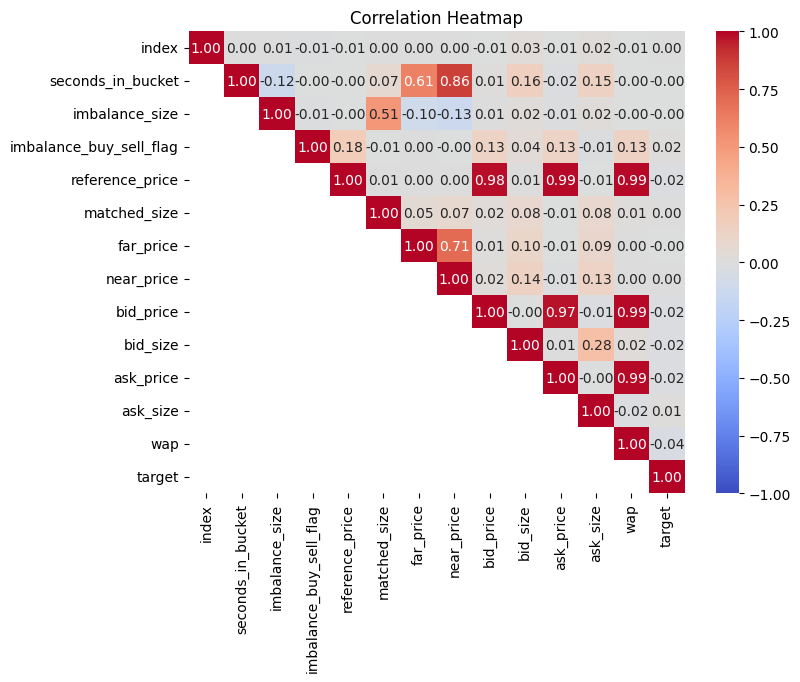

In [35]:
# Calculate the correlation matrix
corr_matrix = corr_df.corr()
# Create a lower triangular mask
mask = ~np.tri(*corr_matrix.values.shape, k=-1, dtype=bool)

# Apply the mask to set the upper triangle values to NaN
corr_matrix = pd.DataFrame(corr_matrix.values * mask, columns=corr_matrix.columns, index=corr_matrix.index)
# Replace very small values with NaN
corr_matrix = corr_matrix.applymap(lambda x: np.nan if abs(x) < 1e-10 else x)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [36]:
# Get feature importances
importances = lgbm_model.feature_importances_

In [37]:
feat_importances = pd.DataFrame({'Value':importances,'Feature':feature_list}).sort_values(by="Value",ascending=False)

In [38]:
feat_importances

,Value,Feature
8,721,wap
6,407,ask_price
5,393,bid_price
3,358,reference_price
0,340,seconds_in_bucket
4,242,matched_size
7,235,ask_size
1,191,imbalance_size
2,113,imbalance_buy_sell_flag


<font size="4"> The reference price, ask price, bid price and wap (weight average price) are highly correlated at 95%+ for all. We can retain the weighted average price (wap) as an input our models as it appears to be most significant to the model. We will remove the remaining price variables.

In [39]:
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
               'matched_size', 'ask_size', 'wap']

In [40]:
# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(objective = 'mae', random_state = 55)
# Train the model
lgbm_model.fit(X_train[feature_list], y_train)

LGBMRegressor(objective='mae', random_state=55)

In [41]:
# Predict on the training set
y_train_pred = lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred = lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Training Set:
Mean Absolute Error (MAE): 6.439308216768074


Test Set:
Mean Absolute Error (MAE): 6.021794659577404


<font size="4">  The results are slightly less improved at 6.02. 

<font size="4">  It is best practice to remove outliers. Lets see if removing outliers will improve the model performance. 

In [42]:
# Specify the column you want to filter
column_name = 'target'

# Adjust these percentiles according to your preference
lower_percentile = 5
upper_percentile = 95

# Calculate lower and upper bounds
lower_bound = np.percentile(train_df[column_name], lower_percentile)
upper_bound = np.percentile(train_df[column_name], upper_percentile)

# Filter the DataFrame based on the bounds
train_df = train_df[(train_df[column_name] > lower_bound) & (train_df[column_name] < upper_bound)]

In [43]:
X = train_df.drop('target', axis=1)  # Features
y = train_df['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [44]:
# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(objective = 'mae', randome_state = 55)
# Train the model
lgbm_model.fit(X_train[feature_list], y_train)

[LightGBM] [Warning] Unknown parameter: randome_state


LGBMRegressor(objective='mae', randome_state=55)

In [45]:
# Predict on the training set
y_train_pred = lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred = lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Training Set:
Mean Absolute Error (MAE): 4.690937189319748


Test Set:
Mean Absolute Error (MAE): 4.522651860990761


<font size="4">  Removing the outlier values significatnly improved test MAE to 4.5. Data preprocessing is an important step in machine learning. As shown in the example above, "clean and structred" data can make a significant difference in results. Let's try normalizing the data using the StandardScaler module available via sklearn. 

In [46]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train[feature_list])
X_test_scaled = scaler.transform(X_test[feature_list])


In [47]:
# Train the model
lgbm_model.fit(X_train_scaled, y_train.values)

[LightGBM] [Warning] Unknown parameter: randome_state


LGBMRegressor(objective='mae', randome_state=55)

In [48]:
# Predict on the training set
y_train_pred = lgbm_model.predict(X_train_scaled)

# Predict on the test set
y_test_pred = lgbm_model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Training Set:
Mean Absolute Error (MAE): 4.691241702479531


Test Set:
Mean Absolute Error (MAE): 4.522917722179959


<font size="4">  Scaling the data produced nearly identical results. 

<font size="4">  We can try PCA reduction and compare. PCA reduction is a method to reduce the number of features in the model. Recall the features currently in our feature list:

<font size="4"> ***feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
               'matched_size', 'ask_size', 'wap']***

<font size="4">  PCA will reduce (or "combine) the features to a number that we specify. We will trial for n=1, n=2 and n=3.

In [49]:
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
               'matched_size', 'ask_size', 'wap']


for n in [1, 2, 3]:
    # Use PCA to find the most important features
    pca = PCA(n_components=n)  # Use different values of n in each iteration
    X_train_pca = pca.fit_transform(X_train[feature_list])
    X_test_pca = pca.transform(X_test[feature_list])  # Use transform instead of fit_transform for the test set
    
    # Train a new LGBMRegressor on the PCA-transformed data
    lgbm_pca = LGBMRegressor(objective = 'mae', randome_state = 55)
    lgbm_pca.fit(X_train_pca, y_train)

    # Predict on the training set
    y_train_pred = lgbm_pca.predict(X_train_pca)

    # Predict on the test set
    y_test_pred = lgbm_pca.predict(X_test_pca)

    # Calculate Mean Absolute Error (MAE) for training and test sets
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate R-squared (R2) score for training and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Print the results for each trial
    print(f'Trial with n_components = {n}:')
    
    print('Training Set:')
    print(f'Mean Absolute Error (MAE): {mae_train}')

    print('\n')

    print('Test Set:')
    print(f'Mean Absolute Error (MAE): {mae_test}')

    print('\n' + '='*40 + '\n')  # Add a separator for better readability


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


[LightGBM] [Warning] Unknown parameter: randome_state


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


Trial with n_components = 1:
Training Set:
Mean Absolute Error (MAE): 4.727337143708494


Test Set:
Mean Absolute Error (MAE): 4.5477478786054615


[LightGBM] [Warning] Unknown parameter: randome_state
Trial with n_components = 2:
Training Set:
Mean Absolute Error (MAE): 4.724335905485819


Test Set:
Mean Absolute Error (MAE): 4.547989023800043


[LightGBM] [Warning] Unknown parameter: randome_state
Trial with n_components = 3:
Training Set:
Mean Absolute Error (MAE): 4.708474295280755


Test Set:
Mean Absolute Error (MAE): 4.53471430257448




<font size="4">  PCA reduction also does did not appear to imporve our test reults. 

<font size="4">  Next, we can try feature engineering. New features can be derived using the features available in the data set. The newly generated features below were cited from the following notebook:

<font size="4"> https://www.kaggle.com/code/kononenko/tuned-lgbm-best-public-score



In [50]:
train_df["volume"] = train_df.eval("ask_size + bid_size")
train_df["mid_price"] = train_df.eval("(ask_price + bid_price) / 2")
train_df["liquidity_imbalance"] = train_df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
train_df["matched_imbalance"] = train_df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
train_df["size_imbalance"] = train_df.eval("bid_size / ask_size")
train_df["imbalance_momentum"] = train_df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / train_df['matched_size']
train_df["price_spread"] = train_df["ask_price"] - train_df["bid_price"]
train_df["spread_intensity"] = train_df.groupby(['stock_id'])['price_spread'].diff()
train_df['price_pressure'] = train_df['imbalance_size'] * (train_df['ask_price'] - train_df['bid_price'])
train_df['market_urgency'] = train_df['price_spread'] * train_df['liquidity_imbalance']


In [51]:
test_df["volume"] = test_df.eval("ask_size + bid_size")
test_df["mid_price"] = test_df.eval("(ask_price + bid_price) / 2")
test_df["liquidity_imbalance"] = test_df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
test_df["matched_imbalance"] = test_df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
test_df["size_imbalance"] = test_df.eval("bid_size / ask_size")
test_df["imbalance_momentum"] = test_df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / test_df['matched_size']
test_df["price_spread"] = test_df["ask_price"] - test_df["bid_price"]
test_df["spread_intensity"] = test_df.groupby(['stock_id'])['price_spread'].diff()
test_df['price_pressure'] = test_df['imbalance_size'] * (test_df['ask_price'] - test_df['bid_price'])
test_df['market_urgency'] = test_df['price_spread'] * test_df['liquidity_imbalance']


<font size="4"> Check to ensure that the newly created columns do not have missing values.

In [52]:
# Calculate the number of missing values in each column
missing_values_per_col = train_df.isna().sum(axis=0)
print(missing_values_per_col)
print(train_df.shape)

index                        0
stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size               0
imbalance_buy_sell_flag      0
reference_price              0
matched_size                 0
far_price                    0
near_price                   0
bid_price                    0
bid_size                     0
ask_price                    0
ask_size                     0
wap                          0
target                       0
time_id                      0
row_id                       0
volume                       0
mid_price                    0
liquidity_imbalance          0
matched_imbalance            0
size_imbalance               0
imbalance_momentum         200
price_spread                 0
spread_intensity           200
price_pressure               0
market_urgency               0
dtype: int64
(4713602, 28)


In [53]:
# Calculate the number of missing values in each column
missing_values_per_col = test_df.isna().sum(axis=0)
print(missing_values_per_col)
print(test_df.shape)

index                        0
stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size               0
imbalance_buy_sell_flag      0
reference_price              0
matched_size                 0
far_price                    0
near_price                   0
bid_price                    0
bid_size                     0
ask_price                    0
ask_size                     0
wap                          0
time_id                      0
row_id                       0
currently_scored             0
volume                       0
mid_price                    0
liquidity_imbalance          0
matched_imbalance            0
size_imbalance               0
imbalance_momentum         200
price_spread                 0
spread_intensity           200
price_pressure               0
market_urgency               0
dtype: int64
(33000, 28)


<font size="4">  The 200 rows with missing data may be dropped, as this represents an insignificant portion of the dataset. 

In [54]:
train_df.dropna(axis = 0, inplace = True)

In [55]:
# Calculate the number of missing values in each column
missing_values_per_col = train_df.isna().sum(axis=0)
print(missing_values_per_col)

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
volume                     0
mid_price                  0
liquidity_imbalance        0
matched_imbalance          0
size_imbalance             0
imbalance_momentum         0
price_spread               0
spread_intensity           0
price_pressure             0
market_urgency             0
dtype: int64


In [56]:
test_df.dropna(axis = 0, inplace = True)

In [57]:
# Calculate the number of missing values in each column
missing_values_per_col = test_df.isna().sum(axis=0)
print(missing_values_per_col)

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id                    0
row_id                     0
currently_scored           0
volume                     0
mid_price                  0
liquidity_imbalance        0
matched_imbalance          0
size_imbalance             0
imbalance_momentum         0
price_spread               0
spread_intensity           0
price_pressure             0
market_urgency             0
dtype: int64


<font size="4">  Now we can split the updated dataframe into training and test sets. Check to ensure the dataframes have no missing values and check that the length of the respective "X_train, y_train" and "X_test, y_test" data frames are of the same length.

In [58]:
X = train_df.drop('target', axis=1)  # Features
y = train_df['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [59]:
print(X_train.isnull().sum())
print(X_train.shape)

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id                    0
row_id                     0
volume                     0
mid_price                  0
liquidity_imbalance        0
matched_imbalance          0
size_imbalance             0
imbalance_momentum         0
price_spread               0
spread_intensity           0
price_pressure             0
market_urgency             0
dtype: int64
(3770721, 27)


In [60]:
print(X_test.isnull().sum())
print(X_test.shape)

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id                    0
row_id                     0
volume                     0
mid_price                  0
liquidity_imbalance        0
matched_imbalance          0
size_imbalance             0
imbalance_momentum         0
price_spread               0
spread_intensity           0
price_pressure             0
market_urgency             0
dtype: int64
(942681, 27)


In [61]:
print(y_train.isnull().sum())
print(y_train.shape)

0
(3770721,)


In [62]:
print(y_test.isnull().sum())
print(y_test.shape)

0
(942681,)


<font size="4">  We can now fit a new model using the newly created features. We will add those features to our previous feature list.

In [63]:
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
               'matched_size', 'ask_size', 'wap', 'volume', 'mid_price', 'liquidity_imbalance',
               'matched_imbalance', 'size_imbalance', 'imbalance_momentum', 'price_spread', 'spread_intensity',
               'price_pressure', 'market_urgency']

In [64]:
# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(objective = 'mae', random_state = 55)
# Train the model
lgbm_model.fit(X_train[feature_list], y_train)

LGBMRegressor(objective='mae', random_state=55)

In [65]:
# Predict on the training set
y_train_pred = lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred = lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Training Set:
Mean Absolute Error (MAE): 4.644354639846508


Test Set:
Mean Absolute Error (MAE): 4.484122918885316


<font size="4"> Test MAE has slightly improved to 4.486. Lets again reduce the less important and highly correlated featues. 

In [66]:
columns_to_remove = ['stock_id', 'date_id', 'time_id', 'row_id']
# Remove the specified columns
corr_df = train_df.drop(columns=columns_to_remove)

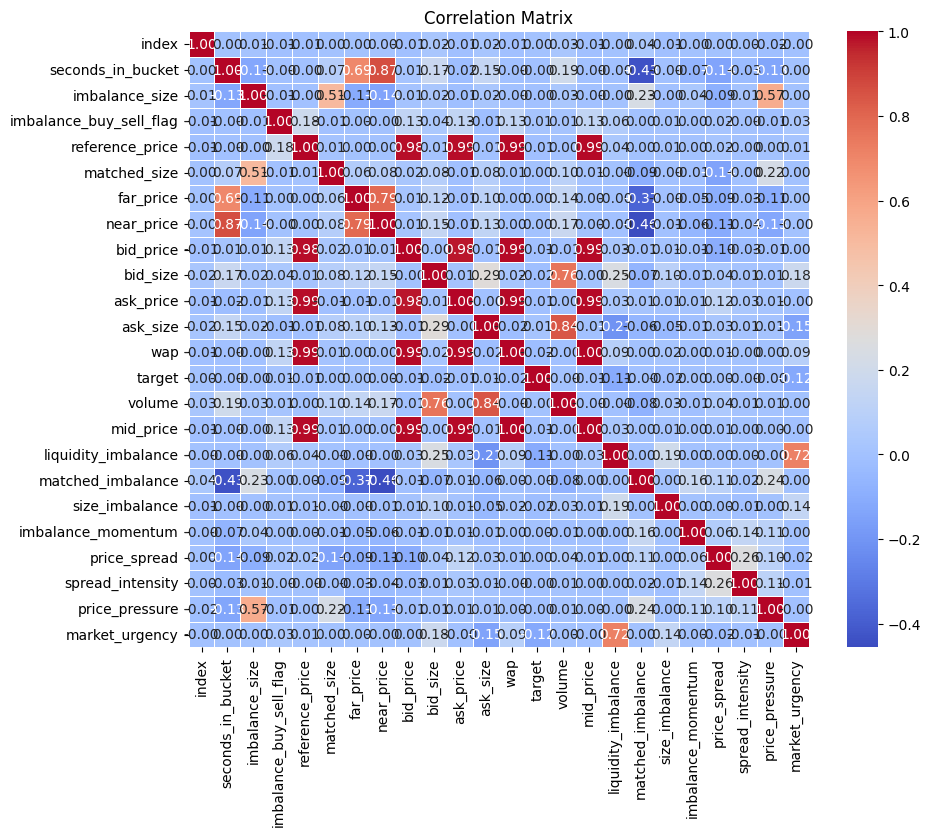

In [67]:
# Calculate the correlation matrix
corr_matrix = corr_df.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<font size="4"> The heat map has gotten a bit crowded, and we are unable to easily visualize high correlations. Let's filter so that we only get correlations of 90% or higher.

In [68]:
# Set the threshold for correlation
correlation_threshold = 0.90

# Filter correlations with absolute value greater than or equal to the threshold
highly_correlated_features = (corr_matrix.abs() >= correlation_threshold) & (corr_matrix.abs() < 1.0)

# Extract the highly correlated features
highly_correlated_features = corr_matrix[highly_correlated_features]

# Display the filtered correlation matrix
highly_correlated_features


,index,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,imbalance_momentum,price_spread,spread_intensity,price_pressure,market_urgency
index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seconds_in_bucket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imbalance_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imbalance_buy_sell_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reference_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984705,NaN,...,NaN,0.991632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matched_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
far_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
near_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bid_price,NaN,NaN,NaN,NaN,0.984705,NaN,NaN,NaN,NaN,NaN,...,NaN,0.993720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bid_size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="4"> Similar to previous findings, only the features related to price are highly correlated. We will continue to use wap (weighted average price) as the price feature in the model and will not include the remaining price variables. We can use the feature_importances_ function available via the LightGBM module to filter for the strongest features. We can take the top 8 most important features of those available to use in the model. Let's see if this will help improve the model.

In [69]:
# Get feature importances
importances = lgbm_model.feature_importances_

In [70]:
feat_importances = pd.DataFrame({'Value':importances,'Feature':feature_list}).sort_values(by="Value",ascending=False)
feat_importances.reset_index(inplace = True)

In [71]:
feat_importances

,index,Value,Feature
0,0,567,seconds_in_bucket
1,3,283,matched_size
2,11,271,imbalance_momentum
3,5,216,wap
4,15,211,market_urgency
5,9,197,matched_imbalance
6,7,163,mid_price
7,2,158,imbalance_buy_sell_flag
8,13,152,spread_intensity
9,12,146,price_spread


In [72]:
feat_importances = feat_importances.iloc[0:8,:]

In [73]:
feature_list = []

In [74]:
for index,thing in enumerate(feat_importances['Feature']):
    #print(index,thing)
    feature_list.append(thing)

In [75]:
feature_list

['seconds_in_bucket',
 'matched_size',
 'imbalance_momentum',
 'wap',
 'market_urgency',
 'matched_imbalance',
 'mid_price',
 'imbalance_buy_sell_flag']

In [76]:
# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(objective = 'mae', random_state = 55)
# Train the model
lgbm_model.fit(X_train[feature_list], y_train)

LGBMRegressor(objective='mae', random_state=55)

In [77]:
# Predict on the training set
y_train_pred_lgbm = lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred_lgbm = lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train_lgbm = mean_absolute_error(y_train, y_train_pred_lgbm)
mae_test_lgbm = mean_absolute_error(y_test, y_test_pred_lgbm)

# Calculate R-squared (R2) score for training and test sets
r2_train_lgbm = r2_score(y_train, y_train_pred_lgbm)
r2_test_lgbm = r2_score(y_test, y_test_pred_lgbm)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train_lgbm}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test_lgbm}')

Training Set:
Mean Absolute Error (MAE): 4.649710750111422


Test Set:
Mean Absolute Error (MAE): 4.490480602362158


<font size="4"> MAE is relativley unchanged at 4.4975. Given this small change, we will keep the reduced feature list to reduce chances of overfitting. 

<font size="4"> Lets try cross validation. For the number of k-folds, we will trial a range of 5 - 10.

In [78]:
# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(objective = 'mae',random_state = 55)

# Define the range of k values
k_range = range(5, 10)

for k in k_range:
    print(f'Number of Folds: {k}')

    # Initialize KFold with k folds
    kf = KFold(n_splits=k, shuffle=False)

    # Lists to store MAE results for each fold
    train_mae_list = []
    test_mae_list = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model on the training fold
        lgbm_model.fit(X_train_fold[feature_list], y_train_fold)

        # Predict on the training fold
        y_train_fold_pred = lgbm_model.predict(X_train_fold[feature_list])

        # Predict on the validation fold
        y_val_fold_pred = lgbm_model.predict(X_val_fold[feature_list])

        # Calculate MAE for the training and validation folds
        mae_train_fold = mean_absolute_error(y_train_fold, y_train_fold_pred)
        mae_val_fold = mean_absolute_error(y_val_fold, y_val_fold_pred)

        train_mae_list.append(mae_train_fold)
        test_mae_list.append(mae_val_fold)

    # Calculate and print the average MAE across folds
    avg_train_mae = np.mean(train_mae_list)
    avg_test_mae = np.mean(test_mae_list)

    print(f'Average Training MAE: {avg_train_mae}')
    print(f'Average Validation MAE: {avg_test_mae}')
    print('\n' + '='*40 + '\n')


Number of Folds: 5
Average Training MAE: 4.648118603872542
Average Validation MAE: 4.658648777376275


Number of Folds: 6
Average Training MAE: 4.648442689218105
Average Validation MAE: 4.658395056152089


Number of Folds: 7
Average Training MAE: 4.648457208312702
Average Validation MAE: 4.657651148549163


Number of Folds: 8
Average Training MAE: 4.64874288660595
Average Validation MAE: 4.657605619936309


Number of Folds: 9
Average Training MAE: 4.648736026709162
Average Validation MAE: 4.65746250300562




<font size="4"> Cross validation also did not improve our test results.

<font size="4"> Lastly, we can try a grid search to find the best parameters. Information regarding parameters available in the LightGBM package may be found in the module's documentation. I encourage users to explore the many parameters available using this technique. For the purposes of time, only a few parameters will be explored:

<font size="4"> https://lightgbm.readthedocs.io/en/latest/Parameters.html
    

In [79]:
# Define the parameter grid for grid search
param_grid = {
    'boosting_type': ['gbdt', 'rf'],
    'n_estimators': [100, 500],
    'num_leaves': [31, 62],
    'bagging_freq': [1],  # Required for rf boosting type
    'bagging_fraction': [0.8],  # Required for rf boosting type
    'objective': ['mae'],
}

# Initialize the LightGBM regressor
lgbm_model = LGBMRegressor(random_state=55)

# Initialize GridSearchCV with the LightGBM model, parameter grid, and scoring metric
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5  # 5-fold cross-validation
)

# Fit the grid search to the data
grid_search.fit(X_train[feature_list], y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to train the final model
best_lgbm_model = LGBMRegressor(**best_params)
best_lgbm_model.fit(X_train[feature_list], y_train)

# Predict on the training set
y_train_pred = best_lgbm_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred = best_lgbm_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calculate R-squared (R2) score for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagg

In [80]:
# Print the results
print(f'Best Parameters: {best_params}')

print(f'\nTraining Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Best Parameters: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'n_estimators': 500, 'num_leaves': 31, 'objective': 'mae'}

Training Set:
Mean Absolute Error (MAE): 4.625208718280496


Test Set:
Mean Absolute Error (MAE): 4.487097545064029


<font size="4"> MAE was relativley unchanged at 4.49. 

<font size="4"> We may move on to neural networks. Tensorflow is a popular Python package for creating neural network models. It is a popular choice amongst Kaggle users, along with gradient descent algorithms (LightGBM, XGBoost and Catboost.) 

<font size="4"> For simplicity, and for the sake of time, we will test one baseline neural network model. Please note that all of the same techniques may be applied when optimizing neural network models and most other algorithms (data preprocessing, feature reduction, feature engineering, cross validation and parameter tuning). 

In [81]:
# Set up the directory for saving the best model
checkpoint_dir = 'keras_models'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the neural network model
model = Sequential()
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

# Compile model with MAE as the loss and use Adam optimizer
model.compile(
    loss='mae',  # Use 'mae' for Mean Absolute Error
    optimizer=Adam(),
    metrics=['mae']  # Monitor MAE during training
)

# Train the model
history = model.fit(
    X_train[feature_list],
    y_train,
    epochs=10,
    batch_size=1024,
    validation_data=(X_test[feature_list], y_test),
    verbose=1
)

# Extract training and validation MAE from history
training_mae = history.history['mae'][-1]
validation_mae = history.history['val_mae'][-1]

# Save the model at the best epoch
best_model_path = os.path.join(checkpoint_dir, 'best_model.h5')
model.save(best_model_path)

# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

# Predict on the test set using the best model
y_train_pred_nn = best_model.predict(X_train[feature_list])
# Predict on the test set using the best model
y_test_pred_nn = best_model.predict(X_test[feature_list])


# Calculate Mean Absolute Error (MAE) for the test set
mae_train_nn = mean_absolute_error(y_train, y_train_pred_nn)
# Calculate Mean Absolute Error (MAE) for the test set
mae_test_nn = mean_absolute_error(y_test, y_test_pred_nn)


# Calculate R-squared (R2) score for training and test sets
r2_train_nn = r2_score(y_train, y_train_pred_nn)
r2_test_nn = r2_score(y_test, y_test_pred_nn)


# Print the results
print(f'Training Set:')
print(f'Final Training Mean Absolute Error (MAE): {mae_train_nn}')

print(f'Mean Absolute Error (MAE) for Neural Network on Test Set: {mae_test_nn}')

Epoch 1/10
3683/3683 [==============================] - 442s 119ms/step - loss: 5312.0811 - mae: 5312.0811 - val_loss: 4.5472 - val_mae: 4.5472
Epoch 2/10
3683/3683 [==============================] - 439s 119ms/step - loss: 7.7066 - mae: 7.7066 - val_loss: 4.5473 - val_mae: 4.5473
Epoch 3/10
3683/3683 [==============================] - 448s 122ms/step - loss: 5.7807 - mae: 5.7807 - val_loss: 4.5473 - val_mae: 4.5473
Epoch 4/10
3683/3683 [==============================] - 457s 124ms/step - loss: 4.9582 - mae: 4.9582 - val_loss: 4.5472 - val_mae: 4.5472
Epoch 5/10
3683/3683 [==============================] - 485s 132ms/step - loss: 5.0245 - mae: 5.0245 - val_loss: 4.5473 - val_mae: 4.5473
Epoch 6/10
3683/3683 [==============================] - 454s 123ms/step - loss: 5.1366 - mae: 5.1366 - val_loss: 4.5472 - val_mae: 4.5472
Epoch 7/10
3683/3683 [==============================] - 440s 120ms/step - loss: 4.8195 - mae: 4.8195 - val_loss: 4.5472 - val_mae: 4.5472
Epoch 8/10
3683/3683 [======

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29459/29459 [==============================] - 81s 3ms/step
Training Set:
Final Training Mean Absolute Error (MAE): 4.72799992073785
Mean Absolute Error (MAE) for Neural Network on Test Set: 4.547207156258358


In [82]:
# Extract training and validation MAE from history
training_mae = history.history['mae'][-1]
validation_mae = history.history['val_mae'][-1]

# Save the model at the best epoch
best_model_path = os.path.join(checkpoint_dir, 'best_model.h5')
model.save(best_model_path)

# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

# Predict on the test set using the best model
y_train_pred_nn = best_model.predict(X_train[feature_list])
# Predict on the test set using the best model
y_test_pred_nn = best_model.predict(X_test[feature_list])


# Calculate Mean Absolute Error (MAE) for the test set
mae_train_nn = mean_absolute_error(y_train, y_train_pred_nn)
# Calculate Mean Absolute Error (MAE) for the test set
mae_test_nn = mean_absolute_error(y_test, y_test_pred_nn)


# Calculate R-squared (R2) score for training and test sets
r2_train_nn = r2_score(y_train, y_train_pred_nn)
r2_test_nn = r2_score(y_test, y_test_pred_nn)


# Print the results
print(f'Training Set:')
print(f'Final Training Mean Absolute Error (MAE): {mae_train_nn}')

print(f'Mean Absolute Error (MAE) for Neural Network on Test Set: {mae_test_nn}')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29459/29459 [==============================] - 79s 3ms/step
Training Set:
Final Training Mean Absolute Error (MAE): 4.72799992073785
Mean Absolute Error (MAE) for Neural Network on Test Set: 4.547207156258358


<font size="4"> Our target metric MAE is relatively unchanged at ~4.5.

<font size="4"> We will trial the remaining algorithms with techniques above. Note that it may be ideal to find the most useful features for each respective algorithm individually. For the purposes of this demonstration, we will use our same feature list above.

In [83]:
# Initialize the CatBoostregressor
cb_model = CatBoostRegressor(loss_function='MAE', verbose = 100)
# Train the model
cb_model.fit(X_train[feature_list], y_train)

# Predict on the training set
y_train_pred_cb = cb_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred_cb = cb_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train_cb = mean_absolute_error(y_train, y_train_pred_cb)
mae_test_cb = mean_absolute_error(y_test, y_test_pred_cb)

# Calculate R-squared (R2) score for training and test sets
r2_train_cb = r2_score(y_train, y_train_pred_cb)
r2_test_cb = r2_score(y_test, y_test_pred_cb)

0:	learn: 4.7251311	total: 777ms	remaining: 12m 55s
100:	learn: 4.6685053	total: 50.3s	remaining: 7m 27s
200:	learn: 4.6603178	total: 1m 40s	remaining: 6m 41s
300:	learn: 4.6559696	total: 2m 31s	remaining: 5m 50s
400:	learn: 4.6533724	total: 3m 21s	remaining: 5m
500:	learn: 4.6513992	total: 4m 11s	remaining: 4m 10s
600:	learn: 4.6497721	total: 5m	remaining: 3m 19s
700:	learn: 4.6484265	total: 5m 50s	remaining: 2m 29s
800:	learn: 4.6472405	total: 6m 39s	remaining: 1m 39s
900:	learn: 4.6461459	total: 7m 29s	remaining: 49.4s
999:	learn: 4.6451796	total: 8m 19s	remaining: 0us


In [84]:
# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train_cb}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test_cb}')

Training Set:
Mean Absolute Error (MAE): 4.645180638623636


Test Set:
Mean Absolute Error (MAE): 4.486686723916927


In [85]:
# Initialize the XGB regressor
xgb_model = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42)
# Train the model
xgb_model.fit(X_train[feature_list], y_train)

# Predict on the training set
y_train_pred_xgb = xgb_model.predict(X_train[feature_list])

# Predict on the test set
y_test_pred_xgb = xgb_model.predict(X_test[feature_list])

# Calculate Mean Absolute Error (MAE) for training and test sets
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

# Calculate R-squared (R2) score for training and test sets
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)



In [86]:
# Print the results
print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train_xgb}')

print('\n')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test_xgb}')

Training Set:
Mean Absolute Error (MAE): 4.627548631361667


Test Set:
Mean Absolute Error (MAE): 4.490563678428678


<font size="4"> Lastly, we can ensemble our models. Ensembling is a technique used to combine the predictions of two or more models. There are various ensemble techniques available; for this demonstration, we will use the StackingRegressor available via the sklearn module. 

<font size="4"> Note that ensembling could be achived via averaging the predictions of each model, however this may result in a memory error. Also, the TensorFlow neural network is not compatible with the StackingRegressor module. For this reason, we not include the neural network in the ensemble.  

In [87]:
# Define the base models
base_models = [
    ('lgbm', lgbm_model),
    ('catboost', cb_model),
    ('xgboost', xgb_model)
]

# Define the meta-model
meta_model = LGBMRegressor(random_state = 55)

# Create the stacked model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
# Train the stacked model
stacked_model.fit(X_train[feature_list], y_train)


# Make predictions on the train set
stacked_predictions_train = stacked_model.predict(X_train[feature_list])

# Make predictions on the test set
stacked_predictions_test = stacked_model.predict(X_test[feature_list])


# Calculate R-squared (R2) score for training and test sets
r2_train_stacked = r2_score(y_train, stacked_predictions_train)
r2_test_stacked = r2_score(y_test, stacked_predictions_test)

0:	learn: 4.7251311	total: 601ms	remaining: 10m
100:	learn: 4.6685053	total: 50.7s	remaining: 7m 31s
200:	learn: 4.6603178	total: 1m 42s	remaining: 6m 46s
300:	learn: 4.6559696	total: 2m 32s	remaining: 5m 53s
400:	learn: 4.6533724	total: 3m 23s	remaining: 5m 4s
500:	learn: 4.6513992	total: 4m 13s	remaining: 4m 12s
600:	learn: 4.6497721	total: 5m 3s	remaining: 3m 21s
700:	learn: 4.6484265	total: 5m 52s	remaining: 2m 30s
800:	learn: 4.6472405	total: 6m 42s	remaining: 1m 40s
900:	learn: 4.6461459	total: 7m 30s	remaining: 49.5s
999:	learn: 4.6451796	total: 8m 20s	remaining: 0us
0:	learn: 4.8570749	total: 436ms	remaining: 7m 15s
100:	learn: 4.8024336	total: 42.1s	remaining: 6m 15s
200:	learn: 4.7938795	total: 1m 21s	remaining: 5m 24s
300:	learn: 4.7893613	total: 2m 2s	remaining: 4m 44s
400:	learn: 4.7864402	total: 2m 41s	remaining: 4m 1s
500:	learn: 4.7843323	total: 3m 22s	remaining: 3m 21s
600:	learn: 4.7825717	total: 4m 1s	remaining: 2m 40s
700:	learn: 4.7810067	total: 4m 41s	remaining: 1

In [88]:
# Evaluate the stacked model
stacked_mae_train = mean_absolute_error(y_train, stacked_predictions_train)
print(f'Stacked Model Mean Absolute Error Train: {stacked_mae_train}')
# Evaluate the stacked model
stacked_mae_test = mean_absolute_error(y_test, stacked_predictions_test)
print(f'Stacked Model Mean Absolute Error Test: {stacked_mae_test}')

Stacked Model Mean Absolute Error Train: 4.645308788002508
Stacked Model Mean Absolute Error Test: 4.487335319401669


<font size="4"> We can view a dataframe with a summary of the model results. 

In [89]:
data = {
    'Algorithm': ['LightGBM', 'Neural Network', 'CatBoost', 'XGBoost', 'Stacked'],
    'MAE_Train': [mae_train_lgbm, mae_train_nn, mae_train_cb, mae_train_xgb, stacked_mae_train],
    'MAE_Test': [mae_test_lgbm, mae_test_nn, mae_test_cb, mae_test_xgb, stacked_mae_test],
    'R2_Train': [r2_train_lgbm, r2_train_nn, r2_train_cb, r2_train_xgb, r2_train_stacked],
    'R2_Test': [r2_test_lgbm, r2_test_nn, r2_test_cb, r2_test_xgb, r2_test_stacked],
}

# Create a DataFrame
metrics_df = pd.DataFrame(data)

# Display the DataFrame
metrics_df

,Algorithm,MAE_Train,MAE_Test,R2_Train,R2_Test
0,LightGBM,4.649711,4.490481,0.026862,2.005579e-02
1,Neural Network,4.728000,4.547207,-0.000005,-9.807208e-07
2,CatBoost,4.645181,4.486687,0.028302,2.139968e-02
3,XGBoost,4.627549,4.490564,0.033536,1.948292e-02
4,Stacked,4.645309,4.487335,0.029445,2.212987e-02


### Summary

<font size="4"> For the desired metric, Mean Average Error (MAE), The algorithms we have tested have fairly similar test results, all with a score of approximately 4.5. The ensemble model also achieved a similar score.

<font size="4"> I found this to be an interesting and challenging regression data set. I was able to take away the following insights after participating in this competition:

- <font size="4">**Preprocessing steps are important:**
  - <font size="4">Recall the importance of exploring to ensure there are no outliers or missing data. The model improved significantly when outliers were removed.
  - <font size="4">Also recall that the “far_price” and “near_price” features in our data set were not used due to the high frequency of missing values. Using those features would likely result in not being able to make predictions as those features would be unavailable at periods of time in live production.
  - <font size="4">It is important to pay attention that the data set is correct and it is important to intuitively understand the variables available in the data set. For example, it may be best for time series data should remain in sequential order.

- <font size="4">**R2 Score as a Metric:**
  - <font size="4">Prior to participating in this competition, I have typically "by default" measured the performance of machine learning models based on the R2 score. It is a popular metric, especially for determining the significance of how independent variables change the target. For this competition, however, I noticed not only that my own R2 results were quite low, but the submission of other users comparatively had low R2 scores. Perhaps this could be due to the difficult nature of predicting "noisy" data such as stock prices. I've learned that it may be counterproductive to "default" to popular metrics in order to apply machine learning techniques to highly competitive tasks such as predicting the stock market.

- <font size="4">**Kaggle Community:**
  - <font size="4">For newer users, I would like to emphasize that the Kaggle community is a great place to learn and stay up-to-date with machine learning algorithms and techniques. I highly suggest downloading and trialing the notebooks of others to help with your data science journey.
  
  
- <font size="4">**Comments and Feedback are welcome:**
  - <font size="4">Thank you to anyone who has taken the time to review this notebook. I would welcome any suggestions for improvementnt, or any interesting comments or insights related to the tournament or machine learning.

In [90]:
submission_df = pd.DataFrame()
submission_df['time_id'] = test_df['time_id']
submission_df['row_id'] = test_df['row_id']
y_pred_test = stacked_model.predict(test_df[feature_list])
submission_df['target'] = y_pred_test
# submission_df.to_csv('submission.csv', index = False)

In [91]:
test_predictions = stacked_model.predict(test_df[feature_list])

In [92]:
# Create the submission dataframe
submission_df = pd.DataFrame({
    'row_id': test_df['row_id'],
    'target': test_predictions
})

In [93]:
# import optiver2023
# env = optiver2023.make_env()
# iter_test = env.iter_test()

In [94]:
# # Iterate through the test data and submit predictions
# for (test, _, sample_prediction) in iter_test:
#     # Set the 'target' column in the sample_prediction dataframe to your model's predictions
#     sample_prediction['target'] = submission_df.loc[submission_df['row_id'].isin(test['row_id']), 'target'].values
#     # Provide the sample_prediction dataframe to the MockApi instance for prediction
#     env.predict(sample_prediction)